In [32]:
import os, sys
import pandas as pd
import matplotlib.pyplot as plt

filepath = os.path.abspath('')
utilpath = f'{filepath}/../util/'
sys.path.append(utilpath)

from melbourne import Melbourne

melb_data = pd.read_hdf(f'{filepath}/../data/melb_data.h5')

# Some optimal parameter configs. R2-Score of ~80%
# n_estimators: 140    max_depth: 14    min_samples_split: 14    max_leaf_nodes: 300    random_state: 1    n_jobs: 6
# n_estimators: 50     max_depth: 16    min_samples_split: 14    max_leaf_nodes: 300    random_state: 1    n_jobs: 6
# n_estimators: 140    max_depth: 18    min_samples_split: 16    max_leaf_nodes: 350    random_state: 1    n_jobs: 8
# n_estimators: 140    max_depth: 20    min_samples_split: 14    max_leaf_nodes: 450    random_state: 1    n_jobs: 8
# n_estimators: 140    max_depth: 22    min_samples_split: 14    max_leaf_nodes: 550    random_state: 1    n_jobs: 8

params = [
    {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split, 
        'max_leaf_nodes': max_leaf_nodes,
        'random_state': 1,
        # 'min_impurity_decrease': min_impurity_decrease,
        'n_jobs': 8,
    }
    for n_estimators in range(100, 180, 10)
    for max_depth in [18, 20, 22]
    for min_samples_split in [14, 16, 18]
    for max_leaf_nodes in [500, 550]
    # for min_impurity_decrease in range(0, 1, .01)
]
param_names = list(params[0].keys())

In [33]:
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, mean_absolute_error

melbourne = Melbourne(melb_data, frac=1)

# metric = mean_absolute_error
metric = mean_squared_error
melbourne.over_under_fit(algorithm=ensemble.RandomForestRegressor, metric=metric, params=params)

data = dict([
    (param_name, [ param[param_name] for param in params])
    for param_name in param_names
])
data[metric.__name__] = melbourne.errors

param_df = pd.DataFrame.from_dict(data)

param_argmin = param_df[metric.__name__].argmin()
param_argmax = param_df[metric.__name__].argmax()
# param_argmin = df.iloc[ [ df[metric.__name__].argmin() ] ]
# WARNING:  Don't pass the argmin as an integer instead of a list containing 
#           that integer, i. e. don't do
#
#               param_argmin = df.iloc[ df[metric.__name__].argmin() ]
#
#           because then `param_argmin` will be a `pandas.Series` and not a
#           `pandas.DataFrame` in which case the dtype information seems to
#           have to be consistent across all entries. This however breaks the 
#           usage of **param_opt as **kwargs in model initialization.

param_opt = dict([
    (param_name, param_df.loc[param_argmin, param_name])
    for param_name in param_names
])

print(f'''
Optimal parameter configuration with minimum {metric.__name__}:

param_opt     =     {'    '.join([ str(f'{p}: {v}') for p, v in param_opt.items()])}
''')

param_df


Optimal parameter configuration with minimum mean_squared_error:

param_opt     =     n_estimators: 130    max_depth: 22    min_samples_split: 14    max_leaf_nodes: 550    random_state: 1    n_jobs: 8



,n_estimators,max_depth,min_samples_split,max_leaf_nodes,random_state,n_jobs,mean_squared_error
0,100,18,14,500,1,8,7.270672e+10
1,100,18,14,550,1,8,7.270291e+10
2,100,18,16,500,1,8,7.295633e+10
3,100,18,16,550,1,8,7.295633e+10
4,100,18,18,500,1,8,7.339435e+10
...,...,...,...,...,...,...,...
139,170,22,14,550,1,8,7.230614e+10
140,170,22,16,500,1,8,7.261767e+10
141,170,22,16,550,1,8,7.261767e+10
142,170,22,18,500,1,8,7.313383e+10


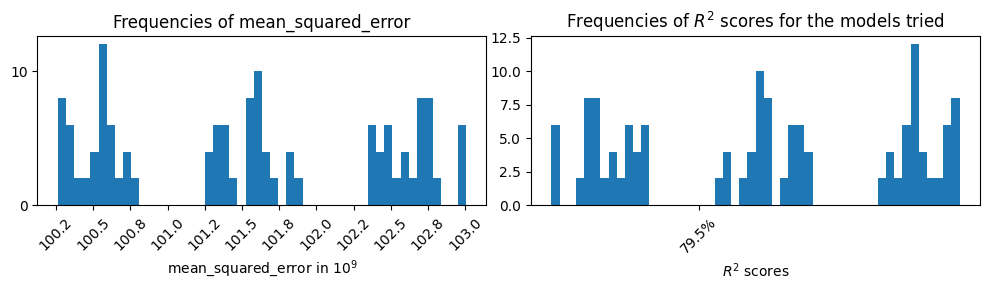

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, MaxNLocator
from matplotlib.ticker import ScalarFormatter, FuncFormatter, PercentFormatter

max_mean_absolute_error = param_df[metric.__name__].max(axis=0)
min_mean_absolute_error = param_df[metric.__name__].min(axis=0)

fig, axes = plt.subplots(1, 2, figsize=(10,3))

ax = axes[0]

ax.hist(melbourne.errors, bins=50)

exponent = np.floor(np.log10(max_mean_absolute_error - min_mean_absolute_error))
base10 = 10 ** exponent

ax.set_title(f'Frequencies of {metric.__name__}')
ax.xaxis.set_major_locator(MultipleLocator(base=base10 / 4))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x / base10 :,.1f}'))
ax.set_xlabel(f'{metric.__name__} in $10^{{{exponent:.0f}}}$')
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.tick_params(axis='x', rotation=45)

ax = axes[1]

r2_argbest, r2_argworst = np.argmax(melbourne.r2_scores), np.argmin(melbourne.r2_scores)
r2_best, r2_worst = melbourne.r2_scores[r2_argbest], melbourne.r2_scores[r2_argworst]
assert param_argmin == r2_argbest and param_argmax == r2_argworst

ax.set_title(f'Frequencies of $R^2$ scores for the models tried')
ax.hist(melbourne.r2_scores, bins=50)

ax.xaxis.set_major_locator(MultipleLocator(base=.005))
ax.xaxis.set_major_formatter(PercentFormatter(1, decimals=1))
ax.set_xlabel(f'$R^2$ scores')
ax.tick_params(axis='x', rotation=45)

fig.tight_layout()
plt.show()

If the $R^2$ scores are within a similar percentage range, we can infer that the parameters are not a decisive game changer for a prediction.
We must therefore change the model.

In [13]:
# Explore the DecisionTreeRegressor with parameters performing best on the test 
# set in more detail.

# Train the best model on all data, not just the training data:

best_melbourne_model = ensemble.RandomForestRegressor(**param_opt)

best_melbourne_model.fit(melbourne.X, melbourne.y)

# Export the DecisionTreeRegressor to jpeg ...

# best_melbourne_model = melbourne.fits[param_argmin]
# best_melbourne_error = melbourne.errors[param_argmin]

# import graphviz
# melbourne_graph = tree.export_graphviz(best_melbourne_model, out_file=None)
# graph = graphviz.Source(melbourne_graph)
# graph.render('melb_tree', format='jpeg')

# ... and predict

best_melbourne_model.fit(melbourne.train_X, melbourne.train_y)

predict_y = best_melbourne_model.predict(melbourne.test_X)

if metric.__name__ == 'mean_squared_error':
    prediction_to_actual_ratio = metric(melbourne.test_y, predict_y) ** .5 / melbourne.mean_price
elif metric.__name__ == 'mean_absolute_error':
    prediction_to_actual_ratio = metric(melbourne.test_y, predict_y) / melbourne.mean_price

print(f'''
prediction-to-actual ratios:
      
{prediction_to_actual_ratio}

mean of prediction-to-actual ratios:

{predict_y.mean(axis=0) / melbourne.mean_price}
''')


prediction-to-actual ratios:
      
0.26404909870279014

mean of prediction-to-actual ratios:

0.987417257459304

